**Data Collection**

Modules

In [1]:
import pandas as pd
import numpy as np
#import geopandas as gpd
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import missingno

from google.colab import files
from io import BytesIO

import warnings
warnings.filterwarnings('ignore')

print("Imports Done")

Imports Done


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Data Import

In [2]:
#county_cases_data = pd.read_csv("https://rajstorage11.blob.core.windows.net/test/us-counties.csv")
#unemployment_data = pd.read_csv("https://rajstorage11.blob.core.windows.net/test/Unemployment.csv", index_col="FIPStxt")
#county_area_data = pd.read_csv("https://rajstorage11.blob.core.windows.net/test/Counties.csv", index_col="GEOID")
#population_data = pd.read_csv("https://rajstorage11.blob.core.windows.net/test/PopulationEstimates.csv", index_col="FIPStxt", encoding='latin-1')

county_cases_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Tech Project/Input Data/us-counties.csv')
unemployment_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Tech Project/Input Data/Unemployment.csv', index_col="FIPStxt")
county_area_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Tech Project/Input Data/Counties.csv', index_col="GEOID")
population_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Tech Project/Input Data/PopulationEstimates.csv', index_col="FIPStxt", encoding='latin-1')

#county_shape_data = gpd.read_file("us-county-shapes/tl_2017_us_county.shp")
county_health_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Tech Project/Input Data/county_health_data_2019.csv')
county_case_history_final = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Tech Project/Input Data/county_case_history_final_file.csv')

#uploaded = files.upload()
#county_health_data = pd.read_csv(BytesIO(uploaded['county_health_data_2019.csv']))
#county_case_history_final = pd.read_csv(BytesIO(uploaded['county_case_history_final_file.csv']))
print("Data Imported")

Data Imported


**Provided Data**

In [3]:
county_case_history_final.head()

,Unnamed: 0,date,fips,county,state,cases,deaths,days_spreading,estimated_r_SIR1,estimated_r_SIR2,estimated_r_ratio14,estimated_r_ratio8
0,0,2020-01-21,53061.0,Snohomish,Washington,1,0,0,1.044893,0.008062,1.0,1.0
1,1,2020-01-22,53061.0,Snohomish,Washington,1,0,1,1.048949,0.009584,1.0,1.0
2,2,2020-01-23,53061.0,Snohomish,Washington,1,0,2,1.053370,0.011393,1.0,1.0
3,3,2020-01-24,53061.0,Snohomish,Washington,1,0,3,1.058190,0.013544,1.0,1.0
4,4,2020-01-25,53061.0,Snohomish,Washington,1,0,4,1.063444,0.016100,1.0,1.0


Geodemographic Data (Population Density, Rural - Urban split)

In [5]:
# Clean and veiw geographic data
geodemographic_data = population_data[["POP_ESTIMATE_2019"]]
geodemographic_data = geodemographic_data.join(county_area_data[["Shape.STArea()"]]).dropna()
geodemographic_data = geodemographic_data.join(unemployment_data[['Rural_urban_continuum_code_2013','Urban_influence_code_2013']])
geodemographic_data = geodemographic_data.rename(columns={'POP_ESTIMATE_2019':'population','Shape.STArea()':'shape area','Rural_urban_continuum_code_2013':'rural-urban_code','Urban_influence_code_2013':'urban-influence_code'})
geodemographic_data["population"] = geodemographic_data["population"].apply(lambda x: int(str(x).replace(",","")))
geodemographic_data["population density"] = geodemographic_data["population"] / (geodemographic_data["shape area"] / 1000000 )
geodemographic_data = geodemographic_data.reset_index().rename(columns={'FIPStxt':'fips'})
geodemographic_data.head()

,fips,population,shape area,rural-urban_code,urban-influence_code,population density
0,1001,55869,2.208657e+09,2.0,2.0,25.295462
1,1003,223234,5.908822e+09,3.0,2.0,37.779782
2,1005,24686,3.257905e+09,6.0,6.0,7.577262
3,1007,22394,2.311989e+09,1.0,1.0,9.686033
4,1009,57826,2.456903e+09,1.0,1.0,23.536137


Economic Data

In [4]:
# Clean and veiw economic data
economic_data = population_data[["POP_ESTIMATE_2019"]]
economic_data = economic_data.join(unemployment_data[["Median_Household_Income_2018",' Civilian_labor_force_2019 ','Unemployment_rate_2019']]).rename(columns={"POP_ESTIMATE_2019":"population","Median_Household_Income_2018": "household_income",' Civilian_labor_force_2019 ':'labor_force','Unemployment_rate_2019':'unemployment'})
economic_data['population'] = economic_data['population'].dropna().apply(lambda x: int(str(x).replace(",","")))
economic_data['household_income'] = economic_data['household_income'].dropna().apply(lambda x: int(str(x).replace(",","")))
economic_data['labor_force'] = economic_data['labor_force'].dropna().apply(lambda x: int(str(x).replace(",","")))
economic_data['% labor_force'] = economic_data['labor_force'] / economic_data['population']
economic_data.head()

,population,household_income,labor_force,unemployment,% labor_force
FIPStxt,,,,,
0,328239523,61937.0,163100055.0,3.7,0.496893
1000,4903185,49881.0,2241747.0,3.0,0.457202
1001,55869,59338.0,26172.0,2.7,0.468453
1003,223234,57588.0,97328.0,2.7,0.435991
1005,24686,34382.0,8537.0,3.8,0.345824


**Government Health Data**

Import Health Data

In [7]:
# Veiw full column count
print('Column Count: {}'.format(len(county_health_data.columns)))

Column Count: 534


Format Health Data

In [8]:
# Clean health data
county_health_data_trim = county_health_data.copy()
county_health_data_trim.drop(county_health_data_trim.index[:2], inplace=True) # Remove unwanted header rows
county_health_data_trim['5-digit FIPS Code'] = county_health_data_trim['5-digit FIPS Code'].astype(int)
cols = ['5-digit FIPS Code','Name','Population raw value','Poor or fair health raw value','Adult smoking raw value','Adult obesity raw value','Physical inactivity raw value','Excessive drinking raw value','Ratio of population to primary care physicians.','Preventable hospital stays raw value','Flu vaccinations raw value','Unemployment raw value','Income inequality raw value','Children in poverty raw value','Violent crime raw value','Air pollution - particulate matter raw value','Severe housing problems raw value','Percentage of households with overcrowding','Life expectancy raw value','Premature age-adjusted mortality raw value','Child mortality raw value','Infant mortality raw value','Diabetes prevalence raw value','Limited access to healthy foods raw value','Uninsured adults raw value','Uninsured children raw value','Ratio of population to primary care providers other than physicians.','Median household income raw value','% below 18 years of age raw value','% 65 and older raw value','% Non-Hispanic African American raw value','% Asian raw value','% Hispanic raw value','% Females raw value','% Rural raw value','Communicable disease raw value','Coronary heart disease hospitalizations raw value','Cancer incidence raw value','Childhood immunizations raw value','Reading proficiency raw value','Poverty raw value','Population growth raw value','Male population 0-17 raw value','Male population 18-44 raw value','Male population 45-64 raw value','Male population 65+ raw value','Total male population raw value','Female population 0-17 raw value','Female population 18-44 raw value','Female population 45-64 raw value','Female population 65+ raw value','Total female population raw value']
county_health_data_trim = county_health_data_trim[cols]
county_health_data_trim.head()

,5-digit FIPS Code,Name,Population raw value,Poor or fair health raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Ratio of population to primary care physicians.,Preventable hospital stays raw value,Flu vaccinations raw value,Unemployment raw value,Income inequality raw value,Children in poverty raw value,Violent crime raw value,Air pollution - particulate matter raw value,Severe housing problems raw value,Percentage of households with overcrowding,Life expectancy raw value,Premature age-adjusted mortality raw value,Child mortality raw value,Infant mortality raw value,Diabetes prevalence raw value,Limited access to healthy foods raw value,Uninsured adults raw value,Uninsured children raw value,Ratio of population to primary care providers other than physicians.,Median household income raw value,% below 18 years of age raw value,% 65 and older raw value,% Non-Hispanic African American raw value,% Asian raw value,% Hispanic raw value,% Females raw value,% Rural raw value,Communicable disease raw value,Coronary heart disease hospitalizations raw value,Cancer incidence raw value,Childhood immunizations raw value,Reading proficiency raw value,Poverty raw value,Population growth raw value,Male population 0-17 raw value,Male population 18-44 raw value,Male population 45-64 raw value,Male population 65+ raw value,Total male population raw value,Female population 0-17 raw value,Female population 18-44 raw value,Female population 45-64 raw value,Female population 65+ raw value,Total female population raw value
2,1000,Alabama,4874747,0.2140240566,0.215381544,0.351,0.282,0.1417814586,1529.3396226,5496,0.42,0.0439678517,5.238579235,0.244,479.91918191,11,0.1491215019,NaN,75.41303499,472.4,71.786041714,8.5105657224,0.139,0.0792142495,0.1384998828,0.0266538976,1322.8621438,48193,0.2247240729,0.1648846597,0.2652090457,0.0146341954,0.0432961957,0.5159059537,0.409631829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1001,Autauga County,55504,0.1841112436,0.191246585,0.375,0.311,0.1687801512,2409.3913043,6599,0.41,0.0386352233,4.6366638778,0.193,272.28222006,11.7,0.1495464575,0.0245158127,76.330589011,438.7,53.279441484,7.6992753623,0.142,0.11991125,0.1096110384,0.0247619048,3264.9411765,58343,0.2393701355,0.1511963102,0.1925446815,0.0127918709,0.0285745172,0.513422456,0.4200216232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1003,Baldwin County,212628,0.1806045782,0.1679548515,0.31,0.238,0.1671496869,1372.125,3833,0.45,0.0398833641,4.5185596041,0.147,203.66039629,10.3,0.1383172525,0.0107280211,78.599497656,348.4,47.000016588,5.8513374486,0.113,0.054244266,0.1357031075,0.0323802671,1915.5675676,56607,0.2184848656,0.1994704366,0.0895319525,0.0115647986,0.0455020035,0.5145277198,0.4227909911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1005,Barbour County,25270,0.2577341563,0.2154087757,0.443,0.282,0.1269871542,2596.5,4736,0.37,0.0590092278,5.7550626063,0.503,414.27786068,11.5,0.1545553145,0.0200650759,75.77945737,469.8,77.080027205,NaN,0.18,0.1073966657,0.1654223969,0.0290142368,4211.6666667,32490,0.2076375148,0.1882469331,0.4794222398,0.004629996,0.0420656905,0.472299169,0.677896347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1007,Bibb County,22668,0.1999691186,0.1991640424,0.378,0.349,0.1592515079,1741.7692308,5998,0.39,0.043851399,4.2545944386,0.273,89.349125982,11.2,0.1096085409,0.0019928826,73.928271076,563.7,111.74968072,14.792899408,0.149,0.0260162701,0.1229731899,0.0261944677,1079.4285714,45795,0.2060614082,0.1602258691,0.2145756132,0.0022057526,0.0263808011,0.4645314981,0.6835260746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Scan Health Data for missing values

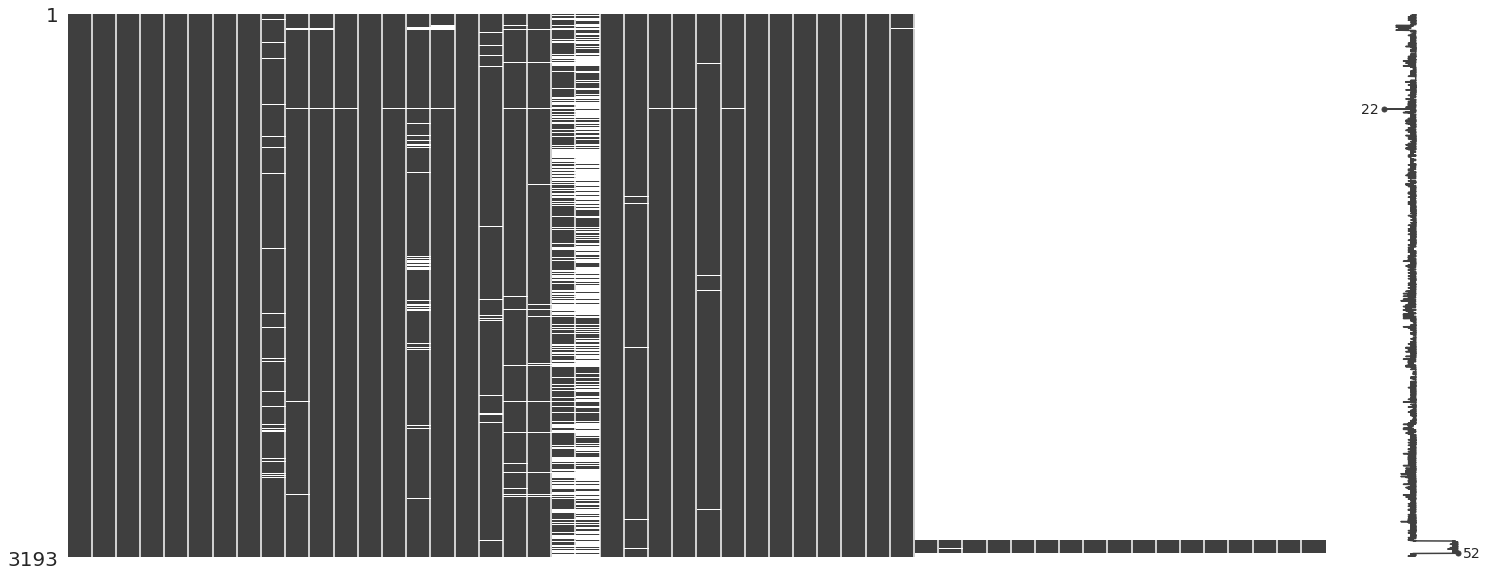

In [25]:
# Plot sparsity matrix
missingno.matrix(county_health_data_trim)

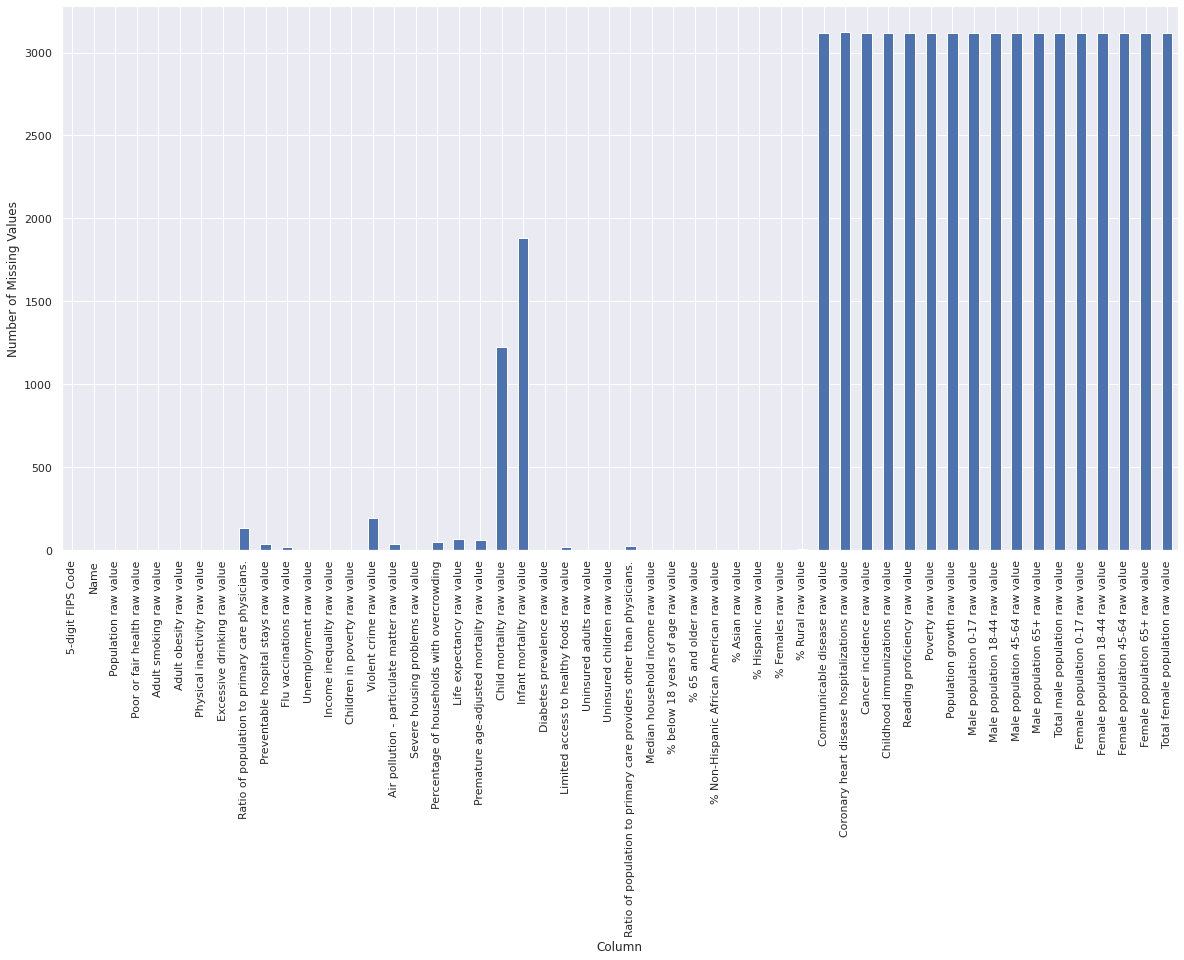

In [24]:
# Plot counts for missing columns
county_health_data_trim.isnull().sum().plot.bar()

In [ ]:
# See Null Rows
county_health_data_trim[county_health_data_trim['Median household income raw value'].isnull()] 

,5-digit FIPS Code,Name,Population raw value,Poor or fair health raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Ratio of population to primary care physicians.,Preventable hospital stays raw value,Flu vaccinations raw value,Unemployment raw value,Income inequality raw value,Children in poverty raw value,Violent crime raw value,Air pollution - particulate matter raw value,Severe housing problems raw value,Percentage of households with overcrowding,Life expectancy raw value,Premature age-adjusted mortality raw value,Child mortality raw value,Infant mortality raw value,Diabetes prevalence raw value,Limited access to healthy foods raw value,Uninsured adults raw value,Uninsured children raw value,Ratio of population to primary care providers other than physicians.,Median household income raw value,% below 18 years of age raw value,% 65 and older raw value,% Non-Hispanic African American raw value,% Asian raw value,% Hispanic raw value,% Females raw value,% Rural raw value,Communicable disease raw value,Coronary heart disease hospitalizations raw value,Cancer incidence raw value,Childhood immunizations raw value,Reading proficiency raw value,Poverty raw value,Population growth raw value,Male population 0-17 raw value,Male population 18-44 raw value,Male population 45-64 raw value,Male population 65+ raw value,Total male population raw value,Female population 0-17 raw value,Female population 18-44 raw value,Female population 45-64 raw value,Female population 65+ raw value,Total female population raw value
562,15005,Kalawao County,88,0.1401714924,0.1267180998,0.228,0.205,0.1665358826,-88,NaN,NaN,NaN,5.4772727273,NaN,NaN,NaN,0.1818181818,0,NaN,NaN,NaN,NaN,0.126,0,NaN,NaN,-88,NaN,0,0.3863636364,0,0.0909090909,0.0113636364,0.5227272727,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Extract Potentially Useful columns

In [ ]:
# Initial selection of potentially useful columns
keep_cols = ['5-digit FIPS Code','Name','Population raw value','Poor or fair health raw value','Adult obesity raw value','Adult smoking raw value','Excessive drinking raw value','Unemployment raw value','Income inequality raw value','Children in poverty raw value','Diabetes prevalence raw value','Uninsured adults raw value','Uninsured children raw value','Median household income raw value','% below 18 years of age raw value','% 65 and older raw value','% Non-Hispanic African American raw value','% Asian raw value','% Hispanic raw value','% Females raw value','% Rural raw value']
renamed_cols = {'5-digit FIPS Code':'fips','Name':'name','Population raw value':'population','Poor or fair health raw value':'poor-fair_health','Adult obesity raw value':'obesity','Adult smoking raw value':'smoking','Excessive drinking raw value':'drinking','Unemployment raw value':'unemployment','Income inequality raw value':'income_inequality','Children in poverty raw value':'child_poverty','Diabetes prevalence raw value':'diabetes','Uninsured adults raw value':'uninsured_adults','Uninsured children raw value':'uninsured_children','Median household income raw value':'household_income','% below 18 years of age raw value':'below_18','% 65 and older raw value':'over_65','% Non-Hispanic African American raw value':'AA','% Asian raw value':'Asian','% Hispanic raw value':'Hispanic','% Females raw value':'female','% Rural raw value':'rural'}
county_health_data_trim_formatted = county_health_data_trim[keep_cols].rename(columns=renamed_cols)
# Enrich dataset with additional columns by combining exisiting factors
county_health_data_trim_formatted['Ethnic_Minority'] = county_health_data_trim_formatted['AA'].astype(float) + county_health_data_trim_formatted['Asian'].astype(float) + county_health_data_trim_formatted['Hispanic'].astype(float)
county_health_data_trim_formatted['uninsured'] = county_health_data_trim_formatted['uninsured_adults'].astype(float) + county_health_data_trim_formatted['uninsured_children'].astype(float)
for col in county_health_data_trim_formatted.columns:
    print(col)
county_health_data_trim_formatted.head()

fips
name
population
poor-fair_health
obesity
smoking
drinking
unemployment
income_inequality
child_poverty
diabetes
uninsured_adults
uninsured_children
household_income
below_18
over_65
AA
Asian
Hispanic
female
rural
Ethnic_Minority
uninsured


,fips,name,population,poor-fair_health,obesity,smoking,drinking,unemployment,income_inequality,child_poverty,diabetes,uninsured_adults,uninsured_children,household_income,below_18,over_65,AA,Asian,Hispanic,female,rural,Ethnic_Minority,uninsured
2,1000,Alabama,4874747,0.2140240566,0.351,0.215381544,0.1417814586,0.0439678517,5.238579235,0.244,0.139,0.1384998828,0.0266538976,48193,0.2247240729,0.1648846597,0.2652090457,0.0146341954,0.0432961957,0.5159059537,0.409631829,0.323139,0.165154
3,1001,Autauga County,55504,0.1841112436,0.375,0.191246585,0.1687801512,0.0386352233,4.6366638778,0.193,0.142,0.1096110384,0.0247619048,58343,0.2393701355,0.1511963102,0.1925446815,0.0127918709,0.0285745172,0.513422456,0.4200216232,0.233911,0.134373
4,1003,Baldwin County,212628,0.1806045782,0.31,0.1679548515,0.1671496869,0.0398833641,4.5185596041,0.147,0.113,0.1357031075,0.0323802671,56607,0.2184848656,0.1994704366,0.0895319525,0.0115647986,0.0455020035,0.5145277198,0.4227909911,0.146599,0.168083
5,1005,Barbour County,25270,0.2577341563,0.443,0.2154087757,0.1269871542,0.0590092278,5.7550626063,0.503,0.18,0.1654223969,0.0290142368,32490,0.2076375148,0.1882469331,0.4794222398,0.004629996,0.0420656905,0.472299169,0.677896347,0.526118,0.194437
6,1007,Bibb County,22668,0.1999691186,0.378,0.1991640424,0.1592515079,0.043851399,4.2545944386,0.273,0.149,0.1229731899,0.0261944677,45795,0.2060614082,0.1602258691,0.2145756132,0.0022057526,0.0263808011,0.4645314981,0.6835260746,0.243162,0.149168


Produce Final Category Data Frames

In [ ]:
# Final category seperation
county_health_data_final = county_health_data_trim_formatted[['fips','poor-fair_health','obesity','below_18','over_65','smoking','drinking']]
county_health_data_final = county_health_data_final.astype(float)
county_ethnicity_data_final = county_health_data_trim_formatted[['fips','Ethnic_Minority','AA','Asian','Hispanic']]
county_ethnicity_data_final = county_ethnicity_data_final.astype(float)
county_socecon_data_final = county_health_data_trim_formatted[['fips','income_inequality','child_poverty','uninsured']] # unemployment, household income
county_socecon_data_final = county_socecon_data_final.astype(float)
county_socecon_data_final = county_socecon_data_final.join(economic_data[['household_income','unemployment','% labor_force']],how='inner',on='fips')
county_geodemographic_data_final = geodemographic_data.join(county_health_data_trim_formatted[['fips','rural']].set_index('fips'),on='fips',how='inner')
county_geodemographic_data_final = county_geodemographic_data_final.astype(float)

In [ ]:
county_health_data_final.head()

,fips,poor-fair_health,obesity,below_18,over_65,smoking,drinking
2,1000.0,0.214024,0.351,0.224724,0.164885,0.215382,0.141781
3,1001.0,0.184111,0.375,0.239370,0.151196,0.191247,0.168780
4,1003.0,0.180605,0.310,0.218485,0.199470,0.167955,0.167150
5,1005.0,0.257734,0.443,0.207638,0.188247,0.215409,0.126987
6,1007.0,0.199969,0.378,0.206061,0.160226,0.199164,0.159252


In [ ]:
county_ethnicity_data_final.head()

,fips,Ethnic_Minority,AA,Asian,Hispanic
2,1000.0,0.323139,0.265209,0.014634,0.043296
3,1001.0,0.233911,0.192545,0.012792,0.028575
4,1003.0,0.146599,0.089532,0.011565,0.045502
5,1005.0,0.526118,0.479422,0.004630,0.042066
6,1007.0,0.243162,0.214576,0.002206,0.026381


In [ ]:
county_socecon_data_final.head()

,fips,income_inequality,child_poverty,uninsured,household_income,unemployment,% labor_force
2,1000.0,5.238579,0.244,0.165154,49881.0,3.0,0.457202
3,1001.0,4.636664,0.193,0.134373,59338.0,2.7,0.468453
4,1003.0,4.518560,0.147,0.168083,57588.0,2.7,0.435991
5,1005.0,5.755063,0.503,0.194437,34382.0,3.8,0.345824
6,1007.0,4.254594,0.273,0.149168,46064.0,3.1,0.387827


In [ ]:
county_geodemographic_data_final.head()

,fips,population,shape area,rural-urban_code,urban-influence_code,population density,rural
0,1001.0,55869.0,2.208657e+09,2.0,2.0,25.295462,0.420022
1,1003.0,223234.0,5.908822e+09,3.0,2.0,37.779782,0.422791
2,1005.0,24686.0,3.257905e+09,6.0,6.0,7.577262,0.677896
3,1007.0,22394.0,2.311989e+09,1.0,1.0,9.686033,0.683526
4,1009.0,57826.0,2.456903e+09,1.0,1.0,23.536137,0.899515


Extract Total Case / Death Data

In [ ]:
county_cases_data.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [ ]:
# Enrich the case / death data with additional columns showing the total cases / deaths as a fraction of the population
county_cases_data_copy = county_cases_data.copy()
county_cases_data_copy = county_cases_data_copy[county_cases_data_copy['fips'].notnull()] # Drop rows with missing values
county_cases_data_copy['fips'] = county_cases_data_copy['fips'].astype(int)
county_total_cases_data = county_cases_data_copy.groupby('fips')['cases'].sum().rename('total cases') # Group data into counties
county_total_deaths_data = county_cases_data_copy.groupby('fips')['deaths'].sum().rename('total deaths')
county_population_data = county_health_data_trim_formatted[['fips','population']].set_index('fips') # Extract Population Data
county_total_cases_deaths = county_total_cases_data.to_frame().join(county_total_deaths_data).join(county_population_data)
county_total_cases_deaths = county_total_cases_deaths.astype(int)
county_total_cases_deaths['% total cases'] = county_total_cases_deaths['total cases'] / county_total_cases_deaths['population'] # Divide by population
county_total_cases_deaths['% total deaths'] = county_total_cases_deaths['total deaths'] / county_total_cases_deaths['population']
county_total_cases_deaths = county_total_cases_deaths.drop('population',axis=1)
county_total_cases_deaths_final = county_total_cases_deaths.reset_index()

In [ ]:
county_total_cases_deaths_final.head()

,fips,total cases,total deaths,% total cases,% total deaths
0,1001,7017,203,0.126423,0.003657
1,1003,13678,368,0.064328,0.001731
2,1005,5038,43,0.199367,0.001702
3,1007,3108,34,0.137110,0.001500
4,1009,2787,25,0.048041,0.000431


Extract Average R values over time

In [ ]:
# Groupby county and take the average over time
county_case_history_av_r = county_case_history_final.copy().groupby('fips').mean().rename(columns={'deaths':'av_deaths','cases':'av_cases','days_spreading':'av_days_spreading','estimated_r_SIR1':'av_r_SIR1','estimated_r_SIR2':'av_r_SIR2','estimated_r_ratio14':'av_r_ratio14','estimated_r_ratio8':'av_r_ratio8'})
county_case_history_av_r = county_case_history_av_r.reset_index().drop('Unnamed: 0',axis=1) # Drop collated dates column
county_case_history_av_r['fips'] = county_case_history_av_r['fips'].astype(int)

In [ ]:
county_case_history_av_r.head()

,fips,av_cases,av_deaths,av_days_spreading,av_r_SIR1,av_r_SIR2,av_r_ratio14,av_r_ratio8
0,1001,55.076923,2.123077,32.0,1.517711,1.555191,2.288632,1.708794
1,1003,124.386667,3.226667,37.0,1.535961,1.859754,4.451256,2.209065
2,1005,46.563636,0.527273,27.0,1.386716,0.847391,2.988587,2.020083
3,1007,33.932203,0.338983,29.0,1.177101,0.171845,2.207158,1.620321
4,1009,28.765625,0.171875,31.5,1.133222,0.127809,1.916137,1.500743


**Features**

Combine All Data Frames to see features

In [ ]:
# Merge our categories into a final features dataframe
features_df = pd.merge(left=county_health_data_final, right=county_ethnicity_data_final, left_on='fips', right_on='fips')
features_df = features_df.join(county_socecon_data_final.set_index('fips'),on='fips')
features_df = features_df.join(county_geodemographic_data_final.set_index('fips'),on='fips')
features_df = features_df.join(county_total_cases_deaths_final.set_index('fips'),on='fips')
features_df = features_df.join(county_case_history_av_r.set_index('fips'),on='fips')
features_df = features_df.dropna()
features_df.head()

,fips,poor-fair_health,obesity,below_18,over_65,smoking,drinking,Ethnic_Minority,AA,Asian,Hispanic,income_inequality,child_poverty,uninsured,household_income,unemployment,% labor_force,population,shape area,rural-urban_code,urban-influence_code,population density,rural,total cases,total deaths,% total cases,% total deaths,av_cases,av_deaths,av_days_spreading,av_r_SIR1,av_r_SIR2,av_r_ratio14,av_r_ratio8
1,1001.0,0.184111,0.375,0.239370,0.151196,0.191247,0.168780,0.233911,0.192545,0.012792,0.028575,4.636664,0.193,0.134373,59338.0,2.7,0.468453,55869.0,2.208657e+09,2.0,2.0,25.295462,0.420022,7017.0,203.0,0.126423,0.003657,55.076923,2.123077,32.0,1.517711,1.555191,2.288632,1.708794
2,1003.0,0.180605,0.310,0.218485,0.199470,0.167955,0.167150,0.146599,0.089532,0.011565,0.045502,4.518560,0.147,0.168083,57588.0,2.7,0.435991,223234.0,5.908822e+09,3.0,2.0,37.779782,0.422791,13678.0,368.0,0.064328,0.001731,124.386667,3.226667,37.0,1.535961,1.859754,4.451256,2.209065
3,1005.0,0.257734,0.443,0.207638,0.188247,0.215409,0.126987,0.526118,0.479422,0.004630,0.042066,5.755063,0.503,0.194437,34382.0,3.8,0.345824,24686.0,3.257905e+09,6.0,6.0,7.577262,0.677896,5038.0,43.0,0.199367,0.001702,46.563636,0.527273,27.0,1.386716,0.847391,2.988587,2.020083
4,1007.0,0.199969,0.378,0.206061,0.160226,0.199164,0.159252,0.243162,0.214576,0.002206,0.026381,4.254594,0.273,0.149168,46064.0,3.1,0.387827,22394.0,2.311989e+09,1.0,1.0,9.686033,0.683526,3108.0,34.0,0.137110,0.001500,33.932203,0.338983,29.0,1.177101,0.171845,2.207158,1.620321
5,1009.0,0.210953,0.344,0.233499,0.178426,0.196522,0.153787,0.113268,0.014600,0.003017,0.095651,4.126883,0.185,0.189947,50412.0,2.7,0.438056,57826.0,2.456903e+09,1.0,1.0,23.536137,0.899515,2787.0,25.0,0.048041,0.000431,28.765625,0.171875,31.5,1.133222,0.127809,1.916137,1.500743


In [ ]:
# Export this data
from google.colab import files

all_features_file = features_df.to_csv("all_features_file.csv")
files.download("all_features_file.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>